# Inferring the effective viscosity and permeability for the Brinkman-Forchheimer model


## The problem we need to solve

The Brinkman-Forchheimer model can be viewed as an extended Darcy’s law and is used to describe
wall-bounded porous media flows:

$$
-\frac{\nu_e}{\epsilon}\nabla^2u+\frac{\nu u}{K}=g,\quad x\in[0,H],
$$


where the solution $u$ is the fluid velocity, $g$ denotes the external force, $\nu$ is the kinetic viscosity of fluid, $\epsilon$ is the porosity of the porous medium, and $K$ is the permeability. The effective viscosity, $\nu_e$, is related to the pore structure and hardly to be determined. A no-slip boundary condition is imposed, i.e., $u(0)=u(1)=0.$ The analytic solution for this problem is

$$u(x)=\frac{gK}\nu\left[1-\frac{\cosh\left(r\left(x-\frac H2\right)\right)}{\cosh\left(\frac{rH}2\right)}\right]$$

with $r=\sqrt{\nu\epsilon/\nu_eK}.$ We choose $H=1,\nu_e=\nu=10^{-3},\epsilon=0.4$, and $K=10^{-3}$, and $g=1.$ To infer $\nu_e$,we
collect the data measurements of the velocity $u$ in only 5 sensor locations.


## Dimensional analysis

**Variables and Parameters:**

1. **Spatial Coordinate, $x$**
   - Typical dimension: length $[x] = L$.

2. **Fluid Velocity, $u(x)$**
   - Velocity dimension: $[u] = L/T$.

3. **Kinematic Viscosity of the Fluid, $\nu$**
   - Kinematic viscosity has dimensions: $[\nu] = L^2/T$.

4. **Effective Viscosity, $\nu_e$**
   - This is also a (generalized) viscosity term, so it has the same dimension as kinematic viscosity: $[\nu_e] = L^2/T$.

5. **Porosity, $\epsilon$**
   - Porosity is a dimensionless measure of void fraction: $[\epsilon] = 1$ (no units).

6. **Permeability, $K$**
   - Permeability has dimensions of area: $[K] = L^2$.

7. **External Force, $g$**
   - The right-hand side $g$ must match the dimensions of the left-hand side terms.
   - Consider the term $-\frac{\nu_e}{\epsilon}\nabla^2 u$:
     $\nabla^2 u \sim u/L^2 = (L/T)/L^2 = 1/(T L)$.
     Multiplying by $\nu_e = L^2/T$ yields $(L^2/T)*(1/(T L)) = L/T^2$.
   - Similarly, $\frac{\nu u}{K} = (L^2/T)*(L/T)/(L^2) = L/T^2$.
   - Thus both terms on the left-hand side have dimension $L/T^2$.
   - Hence, $[g] = L/T^2$.

**Summarized Dimensions:**

- $[x] = L$
- $[u] = L/T$
- $[\nu] = L^2/T$
- $[\nu_e] = L^2/T$
- $[\epsilon] = 1$ (dimensionless)
- $[K] = L^2$
- $[g] = L/T^2$
- $[H] = L$

**Given values (with dimensions):**
- $H=1\,L$
- $\nu_e=10^{-3}\,L^2/T$
- $\nu=10^{-3}\,L^2/T$
- $\epsilon=0.4\,(\text{dimensionless})$
- $K=10^{-3}\,L^2$
- $g=1\,L/T^2$

All chosen parameters are dimensionally consistent with the governing equation.


## Implementation

Import the package we need:

In [1]:
import brainstate as bst
import brainunit as u
import numpy as np

import deepxde.experimental as deepxde


Define the parameters with physical units and the analytical solution:

In [2]:

g = 1 * u.meter / u.second ** 2
v = 1e-3 * u.meter ** 2 / u.second
e = 0.4
H = 1 * u.meter

v_e = bst.ParamState(0.1 * u.meter ** 2 / u.second)
K = bst.ParamState(0.001 * u.meter ** 2)


def sol(x):
    x = x['x'].mantissa
    r = (v.mantissa * e / (1e-3 * 1e-3)) ** 0.5
    y = (
        g.mantissa * 1e-3 /
        v.mantissa *
        (1 - u.math.cosh(r * (x - H.mantissa / 2)) /
         u.math.cosh(r * H.mantissa / 2))
    )
    return {'y': y * u.meter / u.second}


Define the geometry of the problem:

In [3]:

geom = deepxde.geometry.Interval(0, 1).to_dict_point(x=u.meter)


Define the PDE and generate training data:

In [4]:
def pde(x, y):
    du_xx = net.hessian(x)["y"]["x"]["x"]
    return -v_e.value / e * du_xx + v * y['y'] / K.value - g


In [5]:
def gen_traindata(num):
    xvals = np.linspace(1 / (num + 1), 1, num, endpoint=False)
    x = {'x': xvals * u.meter}
    return x, sol(x)

ob_x, ob_u = gen_traindata(5)
observe_u = deepxde.icbc.PointSetBC(ob_x, ob_u)


Define the neural network model:

In [6]:
net = deepxde.nn.Model(
    deepxde.nn.DictToArray(x=u.meter),
    deepxde.nn.FNN(
        [1] + [20] * 3 + [1], "tanh",
        output_transform=lambda x, y: x * (1 - x) * y
    ),
    deepxde.nn.ArrayToDict(y=u.meter / u.second),
)

Define the problem and solve it:

In [7]:
problem = deepxde.problem.PDE(
    geom,
    pde,
    approximator=net,
    solution=sol,
    constraints=[observe_u],
    num_domain=100,
    num_boundary=0,
    train_distribution="uniform",
    num_test=500,
)

Train the model:

Compiling trainer...
'compile' took 0.066302 s

Training trainer...

Step      Train loss                                                Test loss                                                 Test metric                                       
0         [1.2322745 * 10.0^0 * metre ** 2 * second ** -4,          [1.2312626 * 10.0^0 * metre ** 2 * second ** -4,          [{'y': Array(1.0370464, dtype=float32)}]          
           {'ibc0': {'y': 1.0472959 * meter / second}}]              {'ibc0': {'y': 1.0472959 * meter / second}}]                                                               
1000      [0.00070408 * 10.0^0 * metre ** 2 * second ** -4,         [0.00077674 * 10.0^0 * metre ** 2 * second ** -4,         [{'y': Array(0.26238587, dtype=float32)}]         
           {'ibc0': {'y': 0.0429582 * meter / second}}]              {'ibc0': {'y': 0.0429582 * meter / second}}]                                                               
2000      [0.00269285 * 10.0^0 * metre ** 2 * 

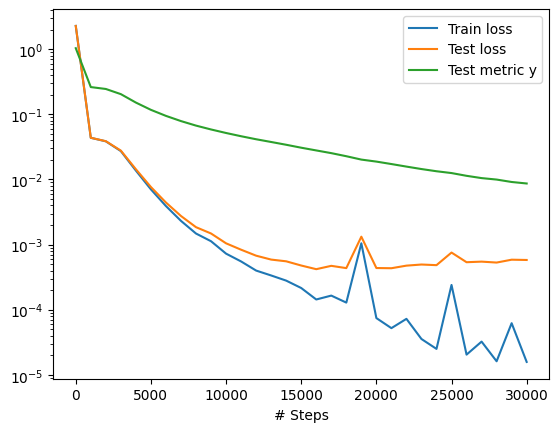

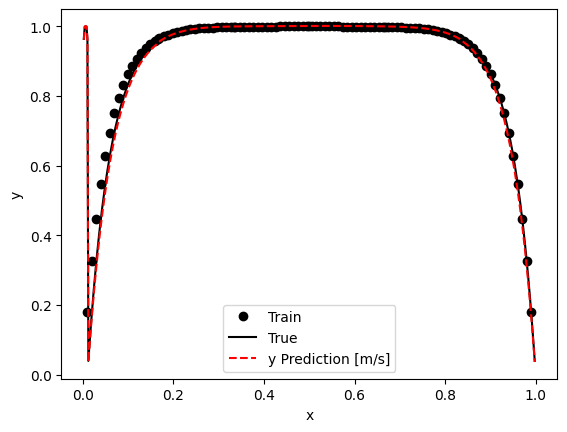

In [8]:
variable = deepxde.callbacks.VariableValue([v_e, K], period=200, filename="../examples-pinn-inverse/variables1.dat")
trainer = deepxde.Trainer(problem, external_trainable_variables=[v_e, K])
trainer.compile(bst.optim.Adam(0.001), metrics=["l2 relative error"]).train(iterations=30000, callbacks=[variable])
trainer.saveplot(issave=True, isplot=True)


The complete code is available in the [Brinkman-Forchheimer model example](https://github.com/lululxvi/deepxde/blob/master/docs/unit-examples-forward/brinkman_forchheimer.py).